In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.kernel_ridge import KernelRidge

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# load the dataset
training_df = pd.read_excel('nonlinear_selected_features.xlsx')

training_df.head()

,355,510,669,1894,1898,2023,2025,2028,2031,Water Potential (Mpa)
0,0.1073,0.0976,0.0513,0.0678,0.0574,0.0702,0.0717,0.0740,0.0763,-0.089632
1,0.0666,0.0691,0.0522,0.0855,0.0757,0.0868,0.0887,0.0904,0.0919,-0.148237
2,0.0624,0.0388,0.0239,0.0533,0.0459,0.0534,0.0549,0.0561,0.0573,-0.128243
3,0.0874,0.0659,0.0448,0.0831,0.0734,0.0808,0.0827,0.0846,0.0861,-0.164785
4,0.0666,0.0394,0.0328,0.0662,0.0573,0.0653,0.0669,0.0683,0.0702,-0.326122


In [3]:
# ---------------------------------
# Define predictors and target
# ---------------------------------
X = training_df.drop(columns = ['Water Potential (Mpa)'])
y = training_df['Water Potential (Mpa)']

In [4]:
# Feature scaling
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Splitting the Dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# <font color = Orange> Multiple Linear Regression - PLSR

In [5]:
# Define the objective function for Optuna
def objective(trial):
    # Set the range for n_components to be integers between 1 and the number of features
    n_components = trial.suggest_int('n_components', 1, X_train.shape[1])
    # Set the range for max_iter to be between 100 and 1000
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    
    # Create the PLSR model with the specified hyperparameters
    model = PLSRegression(n_components=n_components, max_iter=max_iter)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    
    # Return mse as the objective value
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_plsr = PLSRegression(n_components=trial.params['n_components'], max_iter=trial.params['max_iter'])

# Fit the model
best_plsr.fit(X_train, y_train)

# Make predictions
y_pred = best_plsr.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-25 20:41:23,126] A new study created in memory with name: no-name-804108e7-e51f-41cd-aa2a-b25011a6205b
[I 2024-02-25 20:41:23,140] Trial 0 finished with value: 1.8093890504335506 and parameters: {'n_components': 9, 'max_iter': 518}. Best is trial 0 with value: 1.8093890504335506.
[I 2024-02-25 20:41:23,148] Trial 1 finished with value: 1.1699204205541511 and parameters: {'n_components': 2, 'max_iter': 624}. Best is trial 1 with value: 1.1699204205541511.
[I 2024-02-25 20:41:23,168] Trial 2 finished with value: 1.6628414584423554 and parameters: {'n_components': 6, 'max_iter': 716}. Best is trial 1 with value: 1.1699204205541511.
[I 2024-02-25 20:41:23,185] Trial 3 finished with value: 1.5868602596133647 and parameters: {'n_components': 1, 'max_iter': 771}. Best is trial 1 with value: 1.1699204205541511.
[I 2024-02-25 20:41:23,201] Trial 4 finished with value: 1.286416099844485 and parameters: {'n_components': 3, 'max_iter': 778}. Best is trial 1 with value: 1.169920420554151

[I 2024-02-25 20:41:24,984] Trial 46 finished with value: 1.5868602596133647 and parameters: {'n_components': 1, 'max_iter': 108}. Best is trial 1 with value: 1.1699204205541511.
[I 2024-02-25 20:41:25,050] Trial 47 finished with value: 1.1699204205541511 and parameters: {'n_components': 2, 'max_iter': 371}. Best is trial 1 with value: 1.1699204205541511.
[I 2024-02-25 20:41:25,103] Trial 48 finished with value: 1.286416099844485 and parameters: {'n_components': 3, 'max_iter': 571}. Best is trial 1 with value: 1.1699204205541511.
[I 2024-02-25 20:41:25,153] Trial 49 finished with value: 1.5868602596133647 and parameters: {'n_components': 1, 'max_iter': 513}. Best is trial 1 with value: 1.1699204205541511.
[I 2024-02-25 20:41:25,230] Trial 50 finished with value: 1.6888391841473067 and parameters: {'n_components': 4, 'max_iter': 651}. Best is trial 1 with value: 1.1699204205541511.
[I 2024-02-25 20:41:25,297] Trial 51 finished with value: 1.1699204205541511 and parameters: {'n_component

[I 2024-02-25 20:41:27,947] Trial 92 finished with value: 1.1699204205541511 and parameters: {'n_components': 2, 'max_iter': 738}. Best is trial 1 with value: 1.1699204205541511.
[I 2024-02-25 20:41:28,001] Trial 93 finished with value: 1.1699204205541511 and parameters: {'n_components': 2, 'max_iter': 792}. Best is trial 1 with value: 1.1699204205541511.
[I 2024-02-25 20:41:28,054] Trial 94 finished with value: 1.5868602596133647 and parameters: {'n_components': 1, 'max_iter': 654}. Best is trial 1 with value: 1.1699204205541511.
[I 2024-02-25 20:41:28,102] Trial 95 finished with value: 1.286416099844485 and parameters: {'n_components': 3, 'max_iter': 693}. Best is trial 1 with value: 1.1699204205541511.
[I 2024-02-25 20:41:28,154] Trial 96 finished with value: 1.1699204205541511 and parameters: {'n_components': 2, 'max_iter': 603}. Best is trial 1 with value: 1.1699204205541511.
[I 2024-02-25 20:41:28,204] Trial 97 finished with value: 1.1699204205541511 and parameters: {'n_component

Number of finished trials:  100
Best trial:
  Value: 1.1699204205541511
  Params: 
    n_components: 2
    max_iter: 624
Mean Squared Error: 1.1699204205541511
Root Mean Squared Error: 1.0816285964018106
R-Squared value: 0.6113127680878443


In [6]:
# Get the coefficients from the trained PLSRegression model
coefficients = best_plsr.coef_.flatten()

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the features by absolute coefficient values
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, coefficient in sorted_features[:top_n]:
    print(f"{feature}: {coefficient}")

Top 3 Features:
510: 0.24033743041747943
355: 0.23733859952065747
1898: -0.20939276342339153


# <font color = Blue> Elastic Net

In [7]:
# Tune the hyperparameters using Optuna
def objective(trial):
    
    # Set the range for alpha to be uniform between 0.0 and 1.0, alpha is the regularization parameter
    alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
    # Set the range for l1_ratio to be uniform between 0.0 and 1.0, l1_ratio is the ElasticNet mixing parameter
    l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
    # Set the range for max_iter to be between 100 and 1000, max_iter is the maximum number of iterations
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    # Create the ElasticNet model with the specified hyperparameters
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    # Return mse as the objective value
    return mse

# Create the Optuna study, we maximize the objective function (the score)
# model.score() returns the coefficient of determination R^2 of the prediction 
# i.e. the percentage of the variance in the target variable that is predictable from the feature variables
study = optuna.create_study(direction='minimize', sampler = TPESampler(seed=37))
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial

# Print the value of the final trial and the best parameters
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_elastic_net = ElasticNet(alpha=study.best_params['alpha'], l1_ratio=study.best_params['l1_ratio'], max_iter=study.best_params['max_iter'])

# Fit the model
best_elastic_net.fit(X_train, y_train)

# Make predictions
y_pred = best_elastic_net.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-25 20:41:28,412] A new study created in memory with name: no-name-5414a9e9-9c0e-4bb5-b160-45806ffab922
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 20:41:28,428] Trial 0 finished with value: 2.661752803726203 and parameters: {'alpha': 0.9444966028573069, 'l1_ratio': 0.4640981743044076, 'max_iter': 273}. Best is trial 0 with value: 2.661752803726203.
/var/folders/3h/631y9g

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 20:41:28,611] Trial 10 finished with value: 1.3681045682088895 and parameters: {'alpha': 0.27682391622961355, 'l1_ratio': 0.06343733200190918, 'max_iter': 457}. Best is trial 7 with value: 1.3294848425539105.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3317287144.py:5: FutureWarning: suggest_uniform has been deprecate

[I 2024-02-25 20:41:29,093] Trial 19 finished with value: 1.5473426333515936 and parameters: {'alpha': 0.22134439427291244, 'l1_ratio': 0.39244708224006397, 'max_iter': 799}. Best is trial 7 with value: 1.3294848425539105.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 20:41:29,155] Trial 20 finished with value: 1.920877988586511 and parameters: {'alpha': 0.643910652660838, 'l1_ratio'

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 20:41:29,708] Trial 29 finished with value: 2.6700503496538968 and parameters: {'alpha': 0.9668894200089733, 'l1_ratio': 0.45367767313243884, 'max_iter': 863}. Best is trial 26 with value: 1.2844310845327307.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3317287144.py:5: FutureWarning: suggest_uniform has been deprecate

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 20:41:30,190] Trial 39 finished with value: 1.2741707069796921 and parameters: {'alpha': 0.04564610235619748, 'l1_ratio': 0.20820004855315427, 'max_iter': 869}. Best is trial 39 with value: 1.2741707069796921.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3317287144.py:5: FutureWarning: suggest_uniform has been deprecat

[I 2024-02-25 20:41:30,671] Trial 48 finished with value: 1.720331744896508 and parameters: {'alpha': 0.3096506585376336, 'l1_ratio': 0.43586711736593925, 'max_iter': 812}. Best is trial 39 with value: 1.2741707069796921.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 20:41:30,717] Trial 49 finished with value: 1.4245549067940955 and parameters: {'alpha': 0.2537545475950763, 'l1_ratio

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.651e-03, tolerance: 5.990e-03
  model = cd_fast.enet_coordinate_descent(
[I 2024-02-25 20:41:31,242] Trial 58 finished with value: 1.4581526000383127 and parameters: {'alpha': 0.009247998030131557, 'l1_ratio': 0.41139425300813814, 'max_iter': 831}. Best is trial 39 with value: 1.2741707069796921.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3317287144.py:5: Fu

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 20:41:31,829] Trial 67 finished with value: 1.2646654772051262 and parameters: {'alpha': 0.035647542467870344, 'l1_ratio': 0.5225498725162787, 'max_iter': 537}. Best is trial 60 with value: 1.2623564045902016.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3317287144.py:5: FutureWarning: suggest_uniform has been deprecat

[I 2024-02-25 20:41:32,436] Trial 76 finished with value: 1.5329155111729442 and parameters: {'alpha': 0.15855774713545148, 'l1_ratio': 0.674622910263478, 'max_iter': 391}. Best is trial 60 with value: 1.2623564045902016.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 20:41:32,529] Trial 77 finished with value: 1.2723137312657726 and parameters: {'alpha': 0.03754960074085716, 'l1_rati

[I 2024-02-25 20:41:33,265] Trial 85 finished with value: 1.2574293912392014 and parameters: {'alpha': 0.027741930304722152, 'l1_ratio': 0.7138925821639418, 'max_iter': 362}. Best is trial 85 with value: 1.2574293912392014.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 20:41:33,388] Trial 86 finished with value: 1.407965266493464 and parameters: {'alpha': 0.0998866205257912, 'l1_rati

[I 2024-02-25 20:41:34,019] Trial 95 finished with value: 1.3121923229996637 and parameters: {'alpha': 0.05945590037079625, 'l1_ratio': 0.6006893573849866, 'max_iter': 337}. Best is trial 85 with value: 1.2574293912392014.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 20:41:34,081] Trial 96 finished with value: 1.4289558037776993 and parameters: {'alpha': 0.1282225448642623, 'l1_rati

Number of finished trials:  100
Best trial:
  Value: 1.2574293912392014
  Params: 
    alpha: 0.027741930304722152
    l1_ratio: 0.7138925821639418
    max_iter: 362
Mean Squared Error: 1.2574293912392014
Root Mean Squared Error: 1.1213515912679668
R-Squared value: 0.5822393208811163


In [8]:
# Get the coefficients from the trained ElasticNet model
coefficients = best_elastic_net.coef_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the features by absolute coefficient values
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, coefficient in sorted_features[:top_n]:
    print(f"{feature}: {coefficient}")


Top 3 Features:
1894: -0.5683903398109138
1898: -0.3810362257599925
510: 0.23729724605311323


# <font color = Red> Non-linear Kernel Ridge Regression (KRR)

In [9]:
# Define the objective function for Optuna
def objective(trial):
    # Set the range for alpha to be uniform between 0.0 and 1.0
    alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
    # Set the range for gamma to be loguniform between 1e-6 and 1e6
    gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
    # Set the range for kernel to be categorical between 'linear' and 'rbf'
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
    
    # Create the Kernel Ridge Regression model with the specified hyperparameters
    model = KernelRidge(alpha=alpha, gamma=gamma, kernel=kernel)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    
    # Return mse as the objective value
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_krr = KernelRidge(alpha=trial.params['alpha'], gamma=trial.params['gamma'], kernel=trial.params['kernel'])

# Fit the model
best_krr.fit(X_train, y_train)

# Make predictions
y_pred = best_krr.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-25 20:41:34,394] A new study created in memory with name: no-name-db508ac7-24c0-4f4d-b487-796ec4158843
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 20:41:34,438] Trial 0 finished with value: 4.075231077948314 and parameters: {'alpha': 0.9444966028573069, 'gamma': 0.3708327584362581, 'kernel': 'rbf'}. Best is trial 0 with value: 4.075231077948314.
/var/folder

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 20:41:34,611] Trial 10 finished with value: 2.343159038261461 and parameters: {'alpha': 0.003915949640957761, 'gamma': 8.218006795527931e-06, 'kernel': 'rbf'}. Best is trial 10 with value: 2.343159038261461.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/295769073.py:4: FutureWarning: suggest_uniform has be

[I 2024-02-25 20:41:34,970] Trial 19 finished with value: 1.7824758121797024 and parameters: {'alpha': 0.42247919062850353, 'gamma': 0.09155005042423728, 'kernel': 'rbf'}. Best is trial 12 with value: 1.3839387908788392.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 20:41:35,016] Trial 20 finished with value: 2.2170480867661007 and parameters: {'alpha': 0.09214436620061

[I 2024-02-25 20:41:35,470] Trial 29 finished with value: 4.828836762387385 and parameters: {'alpha': 0.9668894200089733, 'gamma': 0.6121389143035458, 'kernel': 'rbf'}. Best is trial 22 with value: 1.3132029721076284.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 20:41:35,506] Trial 30 finished with value: 3.460120268673283 and parameters: {'alpha': 0.7716288161179338, 

[I 2024-02-25 20:41:36,021] Trial 39 finished with value: 1.6673538882795162 and parameters: {'alpha': 0.4591137740723007, 'gamma': 0.024537760454847346, 'kernel': 'rbf'}. Best is trial 22 with value: 1.3132029721076284.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 20:41:36,059] Trial 40 finished with value: 2.80675914745293 and parameters: {'alpha': 0.2299168857066850

[I 2024-02-25 20:41:36,444] Trial 49 finished with value: 1.5914920978757132 and parameters: {'alpha': 0.2064800292851759, 'gamma': 0.0036018574416669404, 'kernel': 'rbf'}. Best is trial 22 with value: 1.3132029721076284.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 20:41:36,476] Trial 50 finished with value: 2.3904206805941666 and parameters: {'alpha': 0.3781779664626

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 20:41:36,811] Trial 59 finished with value: 6.197462058662679 and parameters: {'alpha': 0.2121075015168774, 'gamma': 95174.80565453926, 'kernel': 'rbf'}. Best is trial 52 with value: 1.2432096879859624.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/295769073.py:6: FutureWarning: suggest_loguniform has been

[I 2024-02-25 20:41:37,152] Trial 68 finished with value: 1.241286524696673 and parameters: {'alpha': 0.15235860737411772, 'gamma': 0.05419426537040179, 'kernel': 'rbf'}. Best is trial 65 with value: 1.2236383091262921.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 20:41:37,192] Trial 69 finished with value: 4.884521817874486 and parameters: {'alpha': 0.1027622369934840

[I 2024-02-25 20:41:37,651] Trial 78 finished with value: 1.433445575300451 and parameters: {'alpha': 0.023306309988970014, 'gamma': 0.0005289086954910952, 'kernel': 'rbf'}. Best is trial 65 with value: 1.2236383091262921.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 20:41:37,694] Trial 79 finished with value: 1.318637053876364 and parameters: {'alpha': 0.0668320146248

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 20:41:38,138] Trial 88 finished with value: 4.884501657661643 and parameters: {'alpha': 0.10278669531263557, 'gamma': 0.005909621212613496, 'kernel': 'linear'}. Best is trial 65 with value: 1.2236383091262921.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/295769073.py:6: FutureWarning: suggest_loguniform h

[I 2024-02-25 20:41:38,584] Trial 97 finished with value: 1.2639199852749285 and parameters: {'alpha': 0.03972195978951357, 'gamma': 0.006962102524623618, 'kernel': 'rbf'}. Best is trial 92 with value: 1.2011468884725789.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 20:41:38,637] Trial 98 finished with value: 1.4933300770640334 and parameters: {'alpha': 0.0788515303994

Number of finished trials:  100
Best trial:
  Value: 1.1732456619059861
  Params: 
    alpha: 0.04789661194117299
    gamma: 0.018119756657786812
    kernel: rbf
Mean Squared Error: 1.1732456619059861
Root Mean Squared Error: 1.0831646513369915
R-Squared value: 0.6102080101626237


In [10]:
# Get the dual coefficients from the trained KernelRidge model
coefficients = best_krr.dual_coef_

# Calculate the squared magnitude of coefficients (as they are signed)
squared_magnitude = np.abs(coefficients) ** 2

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, squared_magnitude))

# Sort the features by their squared magnitude (importance)
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, magnitude in sorted_features[:top_n]:
    print(f"{feature}: {magnitude}")


Top 3 Features:
2031: 1264.8147029193751
1894: 1227.712040367854
2025: 302.9821977808065


# Principal Component Regression (PCR)

Number of components that explain at least 95% of the variance: 2


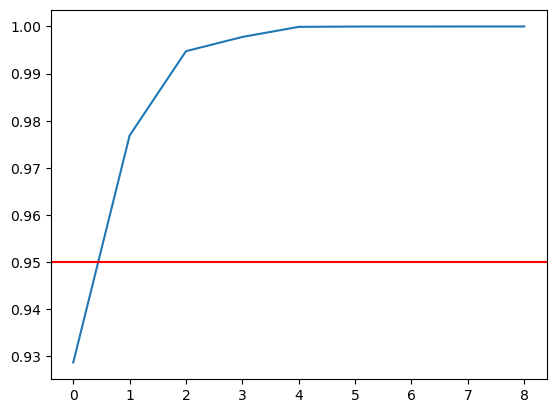

In [11]:
# Create an instance of PCA
pca = PCA(random_state= 37)

# Perform PCA on the predictors DataFrame
pca.fit(X)

# Calculate the cumulative sum of the explained variance ratio
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance with a vertical line at 95%
plt.plot(cumulative_explained_variance)
plt.axhline(y=0.95, color='r', linestyle='-')

# Find the number of components that explain at least 95% of the variance
pca_n_components = np.where(cumulative_explained_variance >= 0.95)[0][0] + 1

print(f'Number of components that explain at least 95% of the variance: {pca_n_components}')

In [12]:
# Define the number of principal components to retain
n_components = pca_n_components

# Create a pipeline with PCA and Linear Regression
pipeline = make_pipeline(PCA(n_components), LinearRegression())

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

Mean Squared Error: 1.1641536830636596
Root Mean Squared Error: 1.0789595372689653
R-Squared value: 0.6132286738135359


In [13]:
# Get the principal components from the trained PCA model within the pipeline
principal_components = pipeline.named_steps['pca'].components_

# Calculate the squared loadings of each feature on the principal components
squared_loadings = principal_components ** 2

# Sum the squared loadings across principal components to get feature importance
feature_importance = squared_loadings.sum(axis=0)

# Get the names of the original features
feature_names = X.columns

# Create a dictionary to store feature importance with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
510: 0.44577719581614783
355: 0.3941641421006784
669: 0.20388170382274895


# <font color = Purple> Ensemble Methods

## <font color = darkgreen> Random Forest Regression

In [14]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Create the Random Forest model with the specified hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the Random Forest model using the best parameters
best_rf_model = RandomForestRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    min_samples_split=trial.params['min_samples_split'], 
    min_samples_leaf=trial.params['min_samples_leaf']
)

# Fit the model
best_rf_model.fit(X_train, y_train)

# Make predictions
y_pred = best_rf_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-25 20:41:39,417] A new study created in memory with name: no-name-2d6ee5fd-d2f4-45cd-9d75-9a3947edd8bc
[I 2024-02-25 20:41:39,883] Trial 0 finished with value: 2.774383809199659 and parameters: {'n_estimators': 145, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 0 with value: 2.774383809199659.
[I 2024-02-25 20:41:40,246] Trial 1 finished with value: 3.0322676177707577 and parameters: {'n_estimators': 112, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 0 with value: 2.774383809199659.
[I 2024-02-25 20:41:40,510] Trial 2 finished with value: 2.893632283048563 and parameters: {'n_estimators': 78, 'max_depth': 24, 'min_samples_split': 17, 'min_samples_leaf': 7}. Best is trial 0 with value: 2.774383809199659.
[I 2024-02-25 20:41:40,820] Trial 3 finished with value: 2.135413235785956 and parameters: {'n_estimators': 94, 'max_depth': 30, 'min_samples_split': 19, 'min_samples_leaf': 2}. Best is trial 3 with value: 2.13

[I 2024-02-25 20:41:50,711] Trial 36 finished with value: 1.9021235721814413 and parameters: {'n_estimators': 72, 'max_depth': 25, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 31 with value: 1.3446287974158848.
[I 2024-02-25 20:41:51,122] Trial 37 finished with value: 2.9180352247971824 and parameters: {'n_estimators': 103, 'max_depth': 19, 'min_samples_split': 13, 'min_samples_leaf': 7}. Best is trial 31 with value: 1.3446287974158848.
[I 2024-02-25 20:41:51,471] Trial 38 finished with value: 2.2797302059652793 and parameters: {'n_estimators': 63, 'max_depth': 22, 'min_samples_split': 11, 'min_samples_leaf': 4}. Best is trial 31 with value: 1.3446287974158848.
[I 2024-02-25 20:41:51,838] Trial 39 finished with value: 2.117981022326671 and parameters: {'n_estimators': 81, 'max_depth': 26, 'min_samples_split': 16, 'min_samples_leaf': 2}. Best is trial 31 with value: 1.3446287974158848.
[I 2024-02-25 20:41:52,191] Trial 40 finished with value: 1.6531985667956903 and par

[I 2024-02-25 20:42:02,821] Trial 72 finished with value: 1.3613423550973869 and parameters: {'n_estimators': 107, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 66 with value: 1.1664046254741935.
[I 2024-02-25 20:42:03,330] Trial 73 finished with value: 1.7736357036165125 and parameters: {'n_estimators': 107, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 66 with value: 1.1664046254741935.
[I 2024-02-25 20:42:03,829] Trial 74 finished with value: 1.406548375654819 and parameters: {'n_estimators': 116, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 66 with value: 1.1664046254741935.
[I 2024-02-25 20:42:04,327] Trial 75 finished with value: 1.3440040048647182 and parameters: {'n_estimators': 118, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 66 with value: 1.1664046254741935.
[I 2024-02-25 20:42:04,747] Trial 76 finished with value: 1.9094708899417656 and paramete

Best trial:
  Value: 1.128819517851779
  Params: 
    n_estimators: 115
    max_depth: 6
    min_samples_split: 2
    min_samples_leaf: 1
Mean Squared Error: 1.3665851769168904
Root Mean Squared Error: 1.1690103408083654
R-Squared value: 0.5459740677605998


## <font color = darkblue> Variable Importance Information of RF

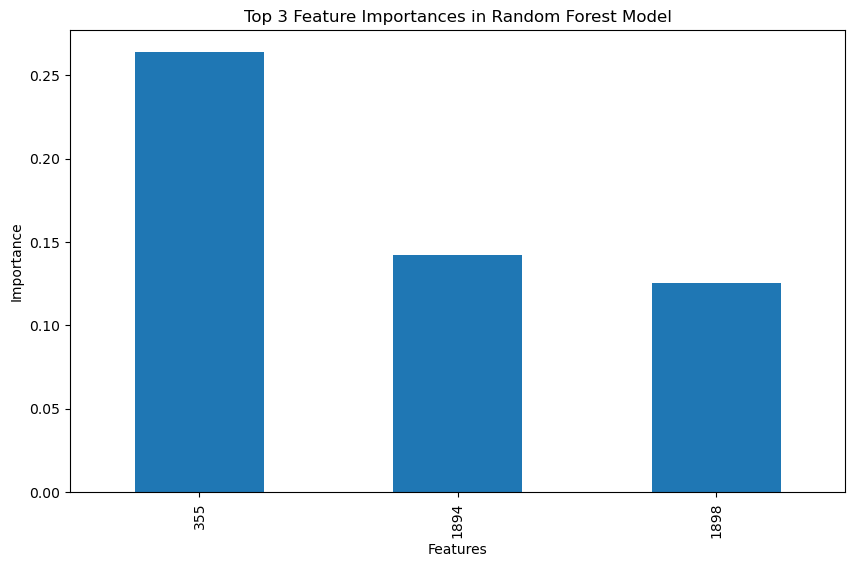

In [15]:
# Extract feature importances
feature_importances = best_rf_model.feature_importances_

# Create a series with feature names and their importance
features = pd.Series(feature_importances, index = X.columns)

# Sort the features by importance
features = features.sort_values(ascending=False)

# Select the top 3 features
top_3_features = features[:3]

# Plot the top 3 feature importances
plt.figure(figsize=(10, 6))
top_3_features.plot(kind='bar')
plt.title('Top 3 Feature Importances in Random Forest Model')
plt.ylabel('Importance')
plt.xlabel('Features')

plt.show()

## <font color = darkgreen> Gradient Boosting Regression

In [20]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)  # Adjust the range for max_depth
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
    
    # Create the Gradient Boosting model with the specified hyperparameters
    model = GradientBoostingRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate  # Pass learning_rate to the model
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the Gradient Boosting model using the best parameters
best_gb_model = GradientBoostingRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    learning_rate=trial.params['learning_rate']  # Pass learning_rate to the model
)

# Fit the model
best_gb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_gb_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))


[I 2024-02-25 21:17:29,162] A new study created in memory with name: no-name-43181f19-d9c4-45ba-8022-5dd9edb46993
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:17:29,357] Trial 0 finished with value: 0.6714418757476407 and parameters: {'n_estimators': 145, 'max_depth': 6, 'learning_rate': 0.027351552606144185}. Best is trial 0 with value: 0.6714418757476407.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.sugg

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:17:31,061] Trial 14 finished with value: 0.522655346038874 and parameters: {'n_estimators': 83, 'max_depth': 5, 'learning_rate': 0.08192989404857401}. Best is trial 11 with value: 0.48514120068217165.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:17:31,245] Trial 15 f

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:17:33,140] Trial 28 finished with value: 1.1356539816033024 and parameters: {'n_estimators': 117, 'max_depth': 3, 'learning_rate': 0.016617718538861223}. Best is trial 20 with value: 0.46870256119966774.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:17:33,303] Trial 2

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:17:35,262] Trial 42 finished with value: 0.4712444860882012 and parameters: {'n_estimators': 115, 'max_depth': 4, 'learning_rate': 0.0871770031488522}. Best is trial 20 with value: 0.46870256119966774.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:17:35,375] Trial 43 

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:17:36,861] Trial 56 finished with value: 0.5163213559429866 and parameters: {'n_estimators': 119, 'max_depth': 4, 'learning_rate': 0.06354292547687208}. Best is trial 20 with value: 0.46870256119966774.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:17:37,024] Trial 57

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:17:38,777] Trial 70 finished with value: 0.9398972702514127 and parameters: {'n_estimators': 116, 'max_depth': 3, 'learning_rate': 0.07686475314457195}. Best is trial 20 with value: 0.46870256119966774.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:17:38,884] Trial 71

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:17:40,777] Trial 84 finished with value: 0.8525720921172506 and parameters: {'n_estimators': 143, 'max_depth': 3, 'learning_rate': 0.09268629541218519}. Best is trial 83 with value: 0.45689849913813707.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:17:40,920] Trial 85

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:17:42,940] Trial 98 finished with value: 0.4573934860608922 and parameters: {'n_estimators': 133, 'max_depth': 4, 'learning_rate': 0.09978502623447191}. Best is trial 97 with value: 0.44921847796190095.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:17:43,117] Trial 99

Best trial:
  Value: 0.44921847796190095
  Params: 
    n_estimators: 129
    max_depth: 4
    learning_rate: 0.09694702405241332
Mean Squared Error: 0.4485222600542674
Root Mean Squared Error: 0.6697180451908604
R-Squared value: 0.8509856972759731


In [17]:
# Get feature importances from the trained GradientBoostingRegressor model
feature_importances = best_gb_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")


Top 3 Features:
355: 0.24110977285247293
669: 0.23532077130504223
1894: 0.1693919625149751


## <font color = green> XGBoost

In [18]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    
    # Create the XGBoost model with the specified hyperparameters
    model = XGBRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the XGBoost model using the best parameters
best_xgb_model = XGBRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    learning_rate=trial.params['learning_rate'],
    min_child_weight=trial.params['min_child_weight'],
    subsample=trial.params['subsample'],
    colsample_bytree=trial.params['colsample_bytree']
)

# Fit the model
best_xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_xgb_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-25 20:42:35,279] A new study created in memory with name: no-name-ae8267c1-781a-4ccd-8e0e-04236ccb6f0d
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

[I 2024-02-25 20:42:40,135] Trial 6 finished with value: 2.5211304377883126 and parameters: {'n_estimators': 114, 'max_depth': 3, 'learning_rate': 0.08254345345232203, 'min_child_weight': 5, 'subsample': 0.5018019421849012, 'colsample_bytree': 0.7326167078381765}. Best is trial 2 with value: 1.4238941474697984.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9g

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-25 20:42:46,951] Trial 19 finished with value: 2.748687509783537 and parameters: {'n_estimators': 77, 'max_depth': 8, 'learning_rate': 0.04988771619827921, 'min_child_weight': 10, 'subsample': 0.7033743947065437, 'colsample_bytree': 0.5769061367059882}. Best is trial 16 with value: 1.3216610136265337.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
[I 2024-02-25 20:42:56,950] Trial 39 finished with value: 2.1705264588509636 and parameters: {'n_estimators': 85, 'max_depth': 8, 'learning_rate': 0.0445363667483415, 'min_child_weight': 4, 'subsample': 0.5448710630517349, 'colsample_bytree': 0.5378545043746739}. Best is trial 16 with value: 1.3216610136265337.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/fol

[I 2024-02-25 20:42:57,961] Trial 45 finished with value: 1.3488324401313532 and parameters: {'n_estimators': 89, 'max_depth': 9, 'learning_rate': 0.054709710255327726, 'min_child_weight': 2, 'subsample': 0.6818169616905477, 'colsample_bytree': 0.593912066909743}. Best is trial 16 with value: 1.3216610136265337.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-25 20:42:59,613] Trial 58 finished with value: 1.7143635741933585 and parameters: {'n_estimators': 66, 'max_depth': 9, 'learning_rate': 0.05991615882309751, 'min_child_weight': 3, 'subsample': 0.694445994092558, 'colsample_bytree': 0.5723265926123902}. Best is trial 52 with value: 1.2708791147952343.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9g

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-25 20:43:01,547] Trial 71 finished with value: 1.2724023995888898 and parameters: {'n_estimators': 55, 'max_depth': 10, 'learning_rate': 0.07790812831132557, 'min_child_weight': 1, 'subsample': 0.6344750337313838, 'colsample_bytree': 0.7253534274449535}. Best is trial 70 with value: 1.20282544932439.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9g

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
[I 2024-02-25 20:43:03,428] Trial 84 finished with value: 1.1224664232978865 and parameters: {'n_estimators': 58, 'max_depth': 5, 'learning_rate': 0.09996183173561798, 'min_child_weight': 1, 'subsample': 0.5917808127182257, 'colsample_bytree': 0.750724942241407}. Best is trial 81 with value: 1.1084754502893621.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/fol

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44552/3853135105.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
[I 2024-02-25 20:43:05,085] Trial 97 finished with value: 1.209516439790129 and parameters: {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.09640141550371766, 'min_child_weight': 1, 'subsample': 0.5922219842354732, 'colsample_bytree': 0.801763803943699}. Best is trial 96 with value: 1.0794765101695853.
/var/folders/3h/63

Best trial:
  Value: 1.0657901685580402
  Params: 
    n_estimators: 57
    max_depth: 5
    learning_rate: 0.08859063375245403
    min_child_weight: 1
    subsample: 0.5397421831336965
    colsample_bytree: 0.8168037786144179
Mean Squared Error: 1.0657901685580402
Root Mean Squared Error: 1.0323711389602288
R-Squared value: 0.6459083685198056


In [19]:
# Get feature importances from the trained XGBoost model
feature_importances = best_xgb_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
1898: 0.2994539439678192
1894: 0.20034146308898926
669: 0.1670212745666504
